# Claims Severity Modeling

Estimate ultimate claim severity for property damage claims and interpret key drivers for reserving teams.

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import shap

plt.style.use("seaborn-v0_8")
sns.set_context("talk")

/Users/michaelmcdonogh/Documents/git/MachineLearningCalculateRiskPremium/CascadeProjects/windsurf-project/insurance-ml-demos/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Generate synthetic severity data

In [2]:
rng = np.random.default_rng(100)
n_samples = 1800

vehicle_age = rng.integers(0, 20, n_samples)
vehicle_value = rng.normal(28000, 9000, n_samples).clip(5000, 75000)
injury_score = rng.beta(2, 5, n_samples) * 10
repair_complexity = rng.choice(["Low", "Moderate", "High"], n_samples, p=[0.45, 0.4, 0.15])
parts_cost_index = rng.normal(1.05, 0.1, n_samples).clip(0.8, 1.4)
labor_hours = rng.normal(18, 6, n_samples).clip(5, 60)
liability_limit = rng.choice([10000, 25000, 50000, 100000], n_samples, p=[0.1, 0.35, 0.4, 0.15])
location = rng.choice(["Urban", "Suburban", "Rural"], n_samples, p=[0.5, 0.35, 0.15])

base_severity = (
    1200
    + 0.18 * vehicle_value
    + 250 * injury_score
    + 320 * labor_hours
    + 6000 * (repair_complexity == "High")
    + 3200 * (repair_complexity == "Moderate")
    + 2500 * (location == "Urban")
    + 1500 * (location == "Suburban")
    + 0.02 * liability_limit
    + rng.normal(0, 1200, n_samples)
)
final_paid = np.clip(base_severity * parts_cost_index, 500, 150000)

severity_df = pd.DataFrame(
    {
        "vehicle_age_years": vehicle_age,
        "vehicle_value": vehicle_value,
        "injury_score": injury_score,
        "repair_complexity": repair_complexity,
        "parts_cost_index": parts_cost_index,
        "labor_hours": labor_hours,
        "liability_limit": liability_limit,
        "location": location,
        "claim_severity": final_paid,
    }
)

Path("data").mkdir(parents=True, exist_ok=True)
data_path = Path("data/claim_severity.csv")
severity_df.to_csv(data_path, index=False)
print(f"Dataset saved to {data_path.resolve()}")
severity_df.head()

Dataset saved to /Users/michaelmcdonogh/Documents/git/MachineLearningCalculateRiskPremium/CascadeProjects/windsurf-project/insurance-ml-demos/data/claim_severity.csv


,vehicle_age_years,vehicle_value,injury_score,repair_complexity,parts_cost_index,labor_hours,liability_limit,location,claim_severity
0,15,26328.433746,5.674906,Low,1.073833,24.396086,100000,Rural,18149.295544
1,16,30474.611609,4.173573,Low,1.156162,23.133217,100000,Urban,24018.953221
2,2,31059.537894,1.663784,Low,1.164585,23.128806,25000,Urban,20722.566602
3,11,6044.267678,1.192100,High,0.956964,16.121641,10000,Suburban,16146.373162
4,1,27106.028063,2.744208,Low,0.910464,17.599981,10000,Rural,11067.748217


## 2. Exploratory analysis

In [3]:
df = pd.read_csv("data/claim_severity.csv")
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
vehicle_age_years,1800.0,9.663333,5.738414,0.000000,5.000000,10.000000,15.000000,19.000000
vehicle_value,1800.0,28048.914447,8823.820437,5000.000000,22228.761314,28040.314572,34034.545896,58841.220544
injury_score,1800.0,2.895676,1.598589,0.099678,1.606737,2.713345,3.990784,8.508678
parts_cost_index,1800.0,1.051025,0.098905,0.800000,0.981483,1.047610,1.118568,1.400000
labor_hours,1800.0,18.099249,5.884506,5.000000,14.205517,17.804312,22.070450,38.903264
liability_limit,1800.0,44977.777778,27046.057428,10000.000000,25000.000000,50000.000000,50000.000000,100000.000000
claim_severity,1800.0,18529.418521,4174.202503,5353.457271,15580.159284,18389.182112,21115.706927,37006.345518


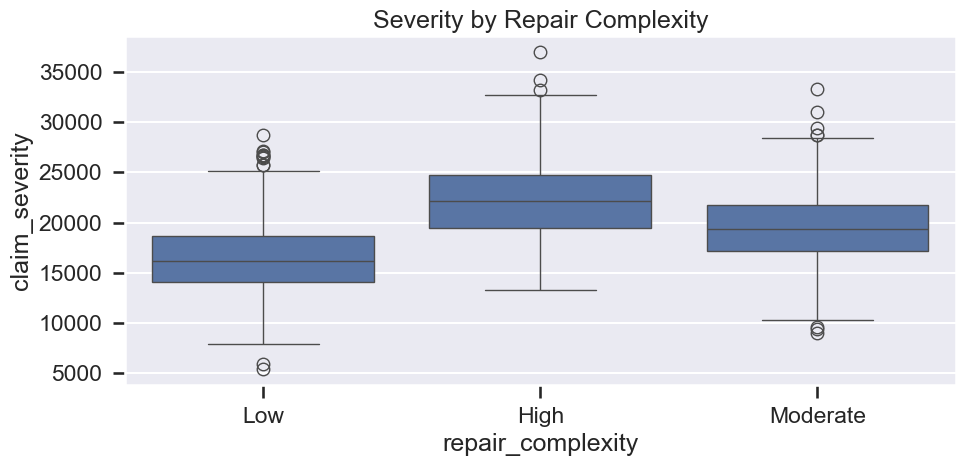

In [4]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x="repair_complexity", y="claim_severity")
plt.title("Severity by Repair Complexity")
plt.tight_layout()
plt.show()

## 3. Model training

In [5]:
features = pd.get_dummies(df.drop(columns=["claim_severity"]), drop_first=True)
target = df["claim_severity"]

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=100
)

model = XGBRegressor(
    random_state=100,
    n_estimators=400,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.85,
    colsample_bytree=0.9,
    objective="reg:squarederror"
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:,.0f}")
print(f"MAE: {mae:,.0f}")
print(f"R^2 : {r2:.3f}")

RMSE: 1,375
MAE: 1,112
R^2 : 0.890


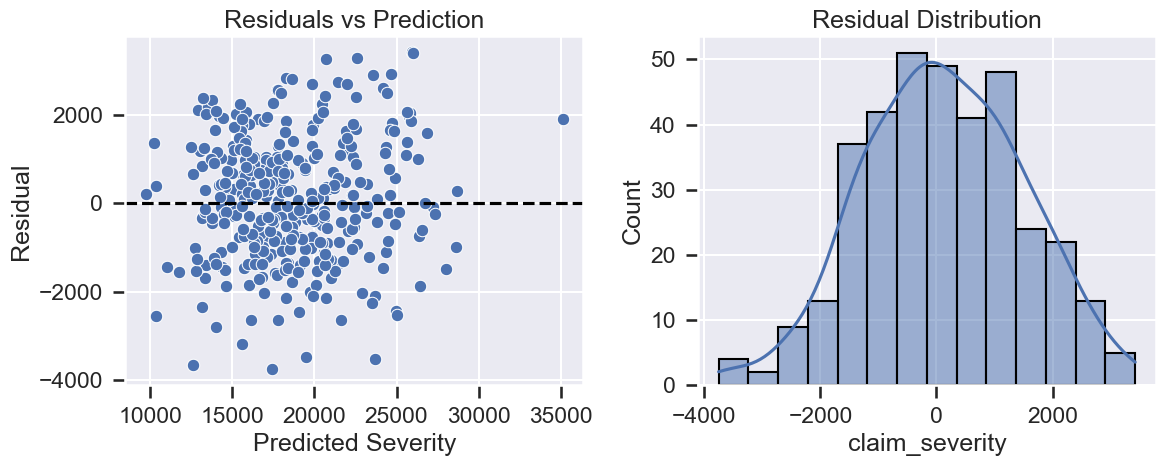

In [6]:
residuals = y_test - y_pred
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='black', linestyle='--')
plt.xlabel("Predicted Severity")
plt.ylabel("Residual")
plt.title("Residuals vs Prediction")

plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution")
plt.tight_layout()
plt.show()

## 4. SHAP-based interpretation

ExactExplainer explainer:  85%|█████████████████████████████████████████████████████████████████████████             | 306/360 [00:00<?, ?it/s]

ExactExplainer explainer:  86%|███████████████████████████████████████████████████████████████████▍          | 311/360 [00:10<00:01, 48.40it/s]

ExactExplainer explainer:  88%|████████████████████████████████████████████████████████████████████▍         | 316/360 [00:10<00:01, 43.66it/s]

ExactExplainer explainer:  89%|█████████████████████████████████████████████████████████████████████▌        | 321/360 [00:10<00:00, 41.61it/s]

ExactExplainer explainer:  91%|██████████████████████████████████████████████████████████████████████▋       | 326/360 [00:10<00:00, 39.95it/s]

ExactExplainer explainer:  92%|███████████████████████████████████████████████████████████████████████▋      | 331/360 [00:10<00:00, 40.00it/s]

ExactExplainer explainer:  93%|████████████████████████████████████████████████████████████████████████▊     | 336/360 [00:10<00:00, 40.33it/s]

ExactExplainer explainer:  95%|█████████████████████████████████████████████████████████████████████████▉    | 341/360 [00:10<00:00, 41.40it/s]

ExactExplainer explainer:  96%|██████████████████████████████████████████████████████████████████████████▉   | 346/360 [00:10<00:00, 40.29it/s]

ExactExplainer explainer:  98%|████████████████████████████████████████████████████████████████████████████  | 351/360 [00:11<00:00, 39.88it/s]

ExactExplainer explainer:  99%|████████████████████████████████████████████████████████████████████████████▉ | 355/360 [00:11<00:00, 39.00it/s]

ExactExplainer explainer: 100%|█████████████████████████████████████████████████████████████████████████████▊| 359/360 [00:11<00:00, 39.13it/s]

ExactExplainer explainer: 361it [00:11,  4.83it/s]                                                                                             


/var/folders/d2/4vnsb4hn5vq5bb7wds771vx80000gn/T/ipykernel_55977/787871689.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance.values[:15], y=importance.index[:15], orient='h', palette='flare')


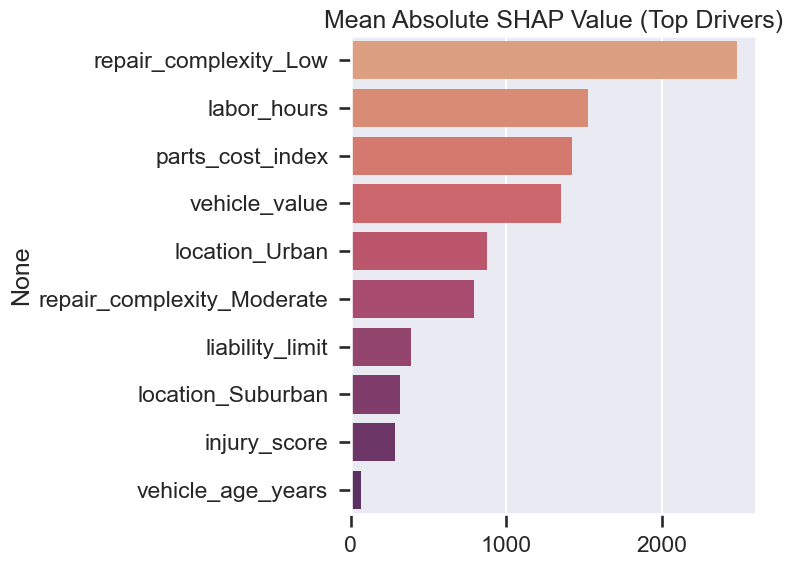

In [7]:
try:
    explainer = shap.TreeExplainer(model)
    shap_output = explainer.shap_values(X_test)
    shap_array = shap_output[0] if isinstance(shap_output, list) else shap_output
except Exception:
    background = shap.sample(X_train, min(200, len(X_train)), random_state=42)
    background_matrix = background.to_numpy(dtype=float, copy=True)
    def predict_fn(data_matrix):
        df = pd.DataFrame(data_matrix, columns=X_test.columns)
        return model.predict(df)
    fallback_explainer = shap.Explainer(predict_fn, background_matrix)
    shap_result = fallback_explainer(X_test.to_numpy(dtype=float, copy=True))
    shap_array = getattr(shap_result, 'values', shap_result)

if hasattr(shap_array, 'values'):
    shap_array = shap_array.values

if shap_array.ndim == 3:
    shap_array = shap_array[:, :, -1]

importance = (
    pd.Series(np.abs(shap_array).mean(axis=0), index=X_test.columns)
    .sort_values(ascending=False)
)

plt.figure(figsize=(8, 6))
sns.barplot(x=importance.values[:15], y=importance.index[:15], orient='h', palette='flare')
plt.title('Mean Absolute SHAP Value (Top Drivers)')
plt.tight_layout()
plt.show()